In [1]:
import functools
import sys

import os
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

In [2]:
seed = 0

torch.manual_seed(seed)

In [3]:
train_data, test_data = datasets.load_dataset('imdb', split=['train', 'test'])

Found cached dataset imdb (/home/yywang/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
transformer_name = 'bert-base-uncased'

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

In [5]:
tokenizer.tokenize('hello world!')

['hello', 'world', '!']

In [6]:
tokenizer.encode('hello world!')

[101, 7592, 2088, 999, 102]

In [7]:
tokenizer.convert_ids_to_tokens(tokenizer.encode('hello world'))

['[CLS]', 'hello', 'world', '[SEP]']

In [8]:
tokenizer('hello world!')

{'input_ids': [101, 7592, 2088, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [9]:
def tokenize_and_numericalize_data(example, tokenizer):
    ids = tokenizer(example['text'], truncation=True)['input_ids']
    return {'ids': ids}

In [10]:
train_data = train_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})
test_data = test_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})

Loading cached processed dataset at /home/yywang/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-6d50d5acc08d383f.arrow
Loading cached processed dataset at /home/yywang/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-4e2a5ef0cae9900e.arrow


In [11]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [12]:
tokenizer.vocab['!']

999

In [13]:
tokenizer.pad_token

'[PAD]'

In [14]:
tokenizer.pad_token_id

0

In [15]:
tokenizer.vocab[tokenizer.pad_token]

0

In [16]:
pad_index = tokenizer.pad_token_id

In [17]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

In [18]:
train_data = train_data.with_format(type='torch', columns=['ids', 'label'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label'])

In [19]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
transformer.config.hidden_size

768

In [21]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False
        
    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:,0,:]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [22]:
output_dim = len(train_data['label'].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [23]:
output_dim

2

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,483,778 trainable parameters


In [25]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)

In [26]:
criterion = nn.CrossEntropyLoss()

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
model = model.to(device)
criterion = criterion.to(device)

In [29]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

In [30]:
batch_size = 32

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [31]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [32]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [33]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [34]:
model = nn.DataParallel(model)

In [35]:
os.environ["CUDA_VISIBLE_DEVICES"]

'4,5,6,7'

In [36]:
n_epochs = 3
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'transformer.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating...: 100%|██████████| 196/196 [00:38<00:00,  5.04it/s]
epoch: 1
train_loss: 0.266, train_acc: 0.887
valid_loss: 0.202, valid_acc: 0.924
evaluating...: 100%|██████████| 196/196 [00:38<00:00,  5.03it/s]
epoch: 2
train_loss: 0.154, train_acc: 0.944
valid_loss: 0.209, valid_acc: 0.928
evaluating...: 100%|██████████| 196/196 [00:39<00:00,  4.99it/s]
epoch: 3
train_loss: 0.096, train_acc: 0.967
valid_loss: 0.245, valid_acc: 0.923


In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

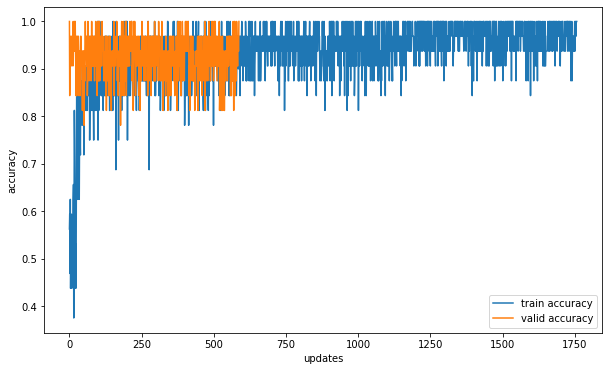

In [38]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [ ]:
model.load_state_dict(torch.load('transformer.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...:  50%|█████     | 391/782 [01:17<01:16,  5.09it/s]

In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)['input_ids']
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [ ]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, device)

In [ ]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, device)

In [ ]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, device)

In [ ]:
###### text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, device)